<a href="https://colab.research.google.com/github/khemthung/MADT8101-Customer-analytics/blob/main/Class6_Topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topics Modeling with LDA

In [1]:
!pip install --upgrade pythainlp
!pip install pyLDAvis

In [2]:
import pandas as pd
import pythainlp
import gensim # to create dict
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [77]:
# Geting file from github
github_url = 'https://raw.githubusercontent.com/khemthung/MADT8101-Customer-analytics/main/Homework%2006%20-%20Social%20Network%20Analytic%20%26%20Social%20Voice%20Analysis/raw_data/wongnai_menya_Itto_bkk_s.csv'
df = pd.read_csv(github_url)

In [76]:
df.head()

,review_id,review,rating,owner,og_link,type
0,1,No.1 from Tokyo\nเมนูเด็ด: Chashu Noko Gyokai ...,4,Pia Patrisha,https://www.wongnai.com/reviews/003cb29b8fdc40...,NaN
1,2,สุดยอดราเมงร้านโปรดในไทย\n\nเมนูเส้นๆนี่เดลิเว...,5,HUNGRYJUG,https://www.wongnai.com/reviews/e6d227d281bf43...,NaN
2,3,ราเมงอันดับ1จากญี่ปุ่น\nMenya Itto ร้านราเมงที...,4,Finedine_hunter,https://www.wongnai.com/reviews/8f7919c726e04f...,NaN
3,4,เค็มนำ รสชาติแปลก เกี๊ยวซ่าดี ชาเขียวดีมีแมลงใ...,1,muJoyce,https://www.wongnai.com/reviews/d1d31098834f41...,NaN
4,5,วันก่อนไปธุระที่เกษร ก็เลยแวะทานราเมนร้านดัง M...,4,Jazzyrain,https://www.wongnai.com/reviews/06afd4ef6ea94a...,NaN


## Tokenize words with pythainlp
- screening & removing words with **TF-IDF** (Term Frequency - Inverse Document Frequency)
- adding custom word list to keep some context [source](https://pythainlp.github.io/docs/2.1/api/tokenize.html)

##### Check and adding custom dict to cut special KW

In [ ]:
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ', '\n', 'ร้าน', '(', ')','++','บาท','.','-',':','฿','‘', '’', '+','฿)','://', '=', '?','ต่อหัว']
screening_words = stopwords + removed_words

def tokenize_with_space(sentence) :
  merged = ''
  words = pythainlp.word_tokenize(str(sentence), engine='newmm')
  for word in words:
    if word not in screening_words:
      merged = merged + ',' + word
  return merged[1:]

In [ ]:
# test custom dict

from pythainlp.corpus.common import thai_words
#from pythainlp.tokenize import Trie, word_tokenize #change dict_trie --> Tier
from pythainlp.tokenize import word_tokenize
from pythainlp.util.trie import Trie, dict_trie

In [ ]:
#test japanese KW normal cut

text = 'ราเมน อ่านว่าราเมง หรือราเมน มีชาชูแท้ๆมาจากโตเกียว อร่อยมาก'

tokens_default = word_tokenize(text, engine="newmm")

tokens_default

['ราเมน',
 ' ',
 'อ่าน',
 'ว่า',
 'รา',
 'เม',
 'ง',
 ' ',
 'หรือ',
 'ราเมน',
 ' ',
 'มี',
 'ชา',
 'ชู',
 'แท้ๆ',
 'มาจาก',
 'โตเกียว',
 ' ',
 'อร่อย',
 'มาก']

In [ ]:
#test create custom dict

custom_dict_japanese_name = set(thai_words())
custom_dict_japanese_name.add('ราเมง')
custom_dict_japanese_name.add('ชาชู')
custom_dict_japanese_name.add('Tsukemen')
custom_dict_japanese_name.add('โตเกียว')
custom_dict_japanese_name.add('เกี๊ยวซ่า')
custom_dict_japanese_name.add('สึเคเมง')

trie = dict_trie(dict_source=custom_dict_japanese_name)
word_tokenize(text, engine="newmm", custom_dict=trie)

['ราเมน',
 ' ',
 'อ่าน',
 'ว่า',
 'ราเมง',
 ' ',
 'หรือ',
 'ราเมน',
 ' ',
 'มี',
 'ชาชู',
 'แท้ๆ',
 'มาจาก',
 'โตเกียว',
 ' ',
 'อร่อย',
 'มาก']

##### begin tokenize

In [52]:
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ','','\n', 'ร้าน', '(', ')','++','บาท','.','-',':','฿','‘', '’', '+','฿)','://','/', '=', '?','ต่อหัว']
screening_words = stopwords + removed_words

# adding regx to clean more special char and numbers
import re
regex_patterns = [r'[0-9]'] #r'[^\w\s\d]'

# custom dict เพราะมี KW ที่ไม่อยากให้ตัดมัวอยู่เช่น 'ราเมง','สึเคเมง','ชาชู','Tsukemen','โตเกียว','เกี๊ยวซ่า'
from pythainlp.corpus.common import thai_words
from pythainlp.tokenize import word_tokenize
from pythainlp.util.trie import Trie, dict_trie

custom_dict_japanese_name = set(thai_words())
custom_dict_japanese_name.add('ราเมง')
custom_dict_japanese_name.add('ชาชู')
custom_dict_japanese_name.add('Tsukemen')
custom_dict_japanese_name.add('โตเกียว')
custom_dict_japanese_name.add('Tokyo')
custom_dict_japanese_name.add('เกี๊ยวซ่า')
custom_dict_japanese_name.add('สึเคเมง')
custom_dict_japanese_name.add('Gaysorn tower')

trie = dict_trie(dict_source=custom_dict_japanese_name)


def tokenize_with_space(sentence):
    merged = ''
    words = pythainlp.word_tokenize(sentence, engine='newmm', custom_dict=trie) #, custom_dict=trie) #multi_cut, deepcut
    for word in words:
        if  word not in screening_words and not any(re.search(pattern, word) for pattern in regex_patterns):
            merged = merged + ',' + word
    return merged[1:]

In [53]:
df['review_tokenized'] = df['review'].apply(lambda x: tokenize_with_space(x))

In [54]:
df_tk = df[['review_id', 'review','review_tokenized']]

In [55]:
df_tk.head(10)

,review_id,review,review_tokenized
0,1,No.1 from Tokyo\nเมนูเด็ด: Chashu Noko Gyokai ...,"No,from,Tokyo,เมนู,เด็ด,Chashu,Noko,Gyokai,Ram..."
1,2,สุดยอดราเมงร้านโปรดในไทย\n\nเมนูเส้นๆนี่เดลิเว...,"สุดยอด,ราเมง,โปรด,ไทย,เมนู,เส้น,เด,ลิ,เวอ,รี่,..."
2,3,ราเมงอันดับ1จากญี่ปุ่น\nMenya Itto ร้านราเมงที...,"ราเมง,อันดับ,ญี่ปุ่น,Menya,Itto,ราเมง,อันดับ,เ..."
3,4,เค็มนำ รสชาติแปลก เกี๊ยวซ่าดี ชาเขียวดีมีแมลงใ...,"เค็ม,รสชาติ,แปลก,เกี๊ยวซ่า,ดี,ชาเขียว,ดี,แมลง,..."
4,5,วันก่อนไปธุระที่เกษร ก็เลยแวะทานราเมนร้านดัง M...,"วันก่อน,ธุระ,เก,ษร,แวะ,ทาน,ราเมน,Menya,Itto,สา..."
5,6,The Best Tsukemen in Bangkok (พค 2022 ย้ายมา G...,"The,Best,Tsukemen,in,Bangkok,(พค,ย้าย,Gaysorn,..."
6,7,หนึ่งในร้านราเมนที่คนรักราเมนคิดถึง โดยเฉพาะ ส...,"ราเมน,คนรัก,ราเมน,คิดถึง,โดยเฉพาะ,สึ,เค,เมน,แถ..."
7,8,ราเมนร้านดังจากโตเกียว\n\nจำได้ว่าตอนร้านเปิดใ...,"ราเมน,โตเกียว,จำได้,ตอน,รอ,คิว,เมนู,signature,..."
8,9,\nได้ยินชื่อเสียงของราเมนร้านนี้จากหลายๆท่านใน...,"ได้ยิน,ชื่อเสียง,ราเมน,ท่าน,วงใน,อันดับ,เว็บ,t..."
9,10,คิวยังยาวอยู่มั้ยคะ เห็นคิวเยอะคนรอนานมาก กลัว...,"คิว,คิว,คน,รอ,กลัว,รอ,เก,อ"


##### Check stopwords list & tokenized words

In [9]:
len(stopwords)

1030

In [ ]:
df_sw = pd.DataFrame(stopwords, columns=['KW'])

In [ ]:
# export for check tokenize
# df_tk.to_csv('work_tokenized.csv', index=False, encoding='utf-8')
df_sw.to_excel('stop_word.xlsx', index=False)
df_tk.to_excel('work_tokenized.xlsx', index=False)

## Create Dictionary
- check bag of words

In [56]:
documents = df_tk['review_tokenized'].to_list()
texts = [[text for text in doc.split(',')] for doc in documents] # for loop แบบย่อ
dictionary = gensim.corpora.Dictionary(texts)

In [57]:
print(dictionary.token2id.keys())

dict_keys(['', 'Chashu', 'Gaysorn', 'Gyokai', 'No', 'Noko', 'Ramen', 'Shio', 'Tokyo', 'Village', 'from', 'juicey', 'ramen', 'กรอบ', 'กลมกล่อม', 'กัด', 'ข้น', 'คน', 'คอ', 'ชั้น', 'ชาชู', 'ชิ้น', 'ซิก', 'ซี', 'ซุป', 'ดี', 'ด้านนอก', 'ด้านใน', 'ตั้งอยู่', 'น้ำ', 'ฟู้ด', 'มาจาก', 'รสชาติ', 'สม', 'สอง', 'สัน', 'สั่ง', 'สาหร่าย', 'หน่อไม้', 'หมู', 'หมูสามชั้น', 'หลง', 'ห้าง', 'อกไก่', 'อร่อย', 'เกี๊ยวซ่า', 'เข้าไป', 'เคี่ยว', 'เจอร์', 'เด็ด', 'เปา', 'เมนู', 'เสิร์ฟ', 'เสี่ยว', 'แป้ง', 'แผ่น', 'แรงบันดาลใจ', 'ไก่', '"', 'B', 'Itto', 'Koiwa', 'Shin', 'Tsukemen', 'tsukemen', 'wadashi', 'กลิ่น', 'กิน', 'กินเส้น', 'กุ้ง', 'คะแนน', 'คิดถึง', 'คิว', 'จมูกข้าว', 'จิ้ม', 'จุ่ม', 'ชิม', 'ซด', 'ซากุระ', 'ซึเคะ', 'ซู', 'ญี่ปุ่น', 'ดีจริง', 'ตอน', 'ติดใจ', 'ทะเล', 'ทำ', 'ทีเด็ด', 'นุ่ม', 'ปลา', 'ปิดท้าย', 'ผสม', 'มาตรฐาน', 'ย่าน', 'รส', 'รอ', 'ราเมง', 'รีบ', 'รี่', 'รู้จัก', 'ร้อน', 'ลด', 'ลิ', 'วาย', 'วี', 'สาขา', 'สำนัก', 'สุดยอด', 'สูด', 'หนัก', 'หนึบ', 'หอย', 'หาย', 'อยู่แล้ว', '฿++', 'เข้มข้น', 'เคร

In [58]:
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in texts]
word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus] # checking มีคำ ซ้ำเท่าไร

## Topic modeling build
- Build the LDA model
- set the topic with k = 3

In [59]:
num_topics = 3
chunksize = 4000 # size of the doc looked at every pass
passes = 20 # no. of passes through documnets
iterations = 50
eval_every = 1 # Don't evaluate model perplextty (tool long time)

# Set index to word dict
temp = dictionary[0] # only to load the dict
id2word = dictionary.id2token

%time model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, \
                                     alpha = 'auto', eta = 'auto', \
                                     iterations=iterations, num_topics=num_topics, \
                                     passes=passes, eval_every=eval_every)

CPU times: user 825 ms, sys: 1.38 ms, total: 827 ms
Wall time: 849 ms


View result

In [60]:
pyLDAvis.gensim.prepare(model, gensim_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.062861 -0.042316       1        1  46.521021
2     -0.075746 -0.023861       2        1  33.655240
1      0.012885  0.066177       3        1  19.823739, topic_info=        Term       Freq      Total Category  logprob  loglift
278    ราเมน  28.000000  28.000000  Default  30.0000  30.0000
29       น้ำ  38.000000  38.000000  Default  29.0000  29.0000
553      ซุบ   4.000000   4.000000  Default  28.0000  28.0000
67       กิน  30.000000  30.000000  Default  27.0000  27.0000
154      ชอบ  20.000000  20.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
60      Itto   2.122754  10.349378   Topic3  -5.4876   0.0341
6      Ramen   2.122675  12.930305   Topic3  -5.4877  -0.1886
180  ส่วนตัว   2.122672   8.103596   Topic3  -5.4877   0.2787
20      ชาชู   2.122657  14.483285   Topic3  -5.4877  -0.3020
189   เหมือน   2.122629   8.047768   Topic3  -5.4877   0.2856

[224 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
58        1  0.899854         "
572       2  0.553651       ...
572       3  0.276825       ...
1         1  0.485844    Chashu
1         2  0.485844    Chashu
...     ...       ...       ...
57        3  0.216161       ไก่
570       3  0.731714  ได้กลิ่น
143       1  0.263893       ไทย
143       2  0.659731       ไทย
571       3  0.731717       ๆ++

[260 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### Topic label and scoring
- adding score back to review and further usage

In [61]:
model.show_topic(0)

[('ซุป', 0.031627957),
 ('เส้น', 0.021605007),
 ('น้ำ', 0.016260477),
 ('รสชาติ', 0.014255003),
 ('กิน', 0.014253449),
 ('ราเมง', 0.012917789),
 ('ดี', 0.012248907),
 ('อร่อย', 0.0115820505),
 ('ชาม', 0.011580608),
 ('เข้มข้น', 0.009577993)]

In [62]:
model.show_topic(1)

[('ราเมน', 0.023993421),
 ('น้ำ', 0.021510953),
 ('ซุป', 0.017787924),
 ('กิน', 0.016548363),
 ('อร่อย', 0.015306342),
 ('ชอบ', 0.01282546),
 ('เค็ม', 0.012824237),
 ('รสชาติ', 0.0115849525),
 ('ดี', 0.011584103),
 ('ลอง', 0.011583128)]

In [63]:
model.show_topic(2)

[('ซุป', 0.014038029),
 ('ราเมน', 0.0140372785),
 ('เมนู', 0.01403495),
 ('รสชาติ', 0.0123176),
 ('อร่อย', 0.011459885),
 ('ทาน', 0.01059747),
 ('Tsukemen', 0.010596579),
 ('เส้น', 0.009741079),
 ('สั่ง', 0.009739685),
 ('ชอบ', 0.009739104)]

In [64]:
# adding topic and score to df_tk for review
df_tk['topic'] = df_tk['review_tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df_tk['score'] = df_tk['review_tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])

<ipython-input-64-3fc6aed9c06e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tk['topic'] = df_tk['review_tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
<ipython-input-64-3fc6aed9c06e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tk['score'] = df_tk['review_tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])


In [69]:
# topic mapping (naming for each topic)
topic_mapping = {
    0: "foodie review",
    1: "ramen lover",
    2: "user experiances",
}

df_tk['topic_title'] = df_tk['topic'].map(topic_mapping)

In [82]:
df_tk.head(5)

,review_id,review,review_tokenized,topic,score,topic_title,rating
0,1,No.1 from Tokyo\nเมนูเด็ด: Chashu Noko Gyokai ...,"No,from,Tokyo,เมนู,เด็ด,Chashu,Noko,Gyokai,Ram...",0,0.999255,foodie review,4
1,2,สุดยอดราเมงร้านโปรดในไทย\n\nเมนูเส้นๆนี่เดลิเว...,"สุดยอด,ราเมง,โปรด,ไทย,เมนู,เส้น,เด,ลิ,เวอ,รี่,...",0,0.999591,foodie review,5
2,3,ราเมงอันดับ1จากญี่ปุ่น\nMenya Itto ร้านราเมงที...,"ราเมง,อันดับ,ญี่ปุ่น,Menya,Itto,ราเมง,อันดับ,เ...",2,0.999387,user experiances,4
3,4,เค็มนำ รสชาติแปลก เกี๊ยวซ่าดี ชาเขียวดีมีแมลงใ...,"เค็ม,รสชาติ,แปลก,เกี๊ยวซ่า,ดี,ชาเขียว,ดี,แมลง,...",0,0.999555,foodie review,1
4,5,วันก่อนไปธุระที่เกษร ก็เลยแวะทานราเมนร้านดัง M...,"วันก่อน,ธุระ,เก,ษร,แวะ,ทาน,ราเมน,Menya,Itto,สา...",1,0.999063,ramen lover,4


In [80]:
#export file
df_tk.to_csv('final_outcome.csv', index=False)
df_tk.to_excel('final_outcome.xlsx', index=False)

## Topic and rating score

In [79]:
# adding topic and score to main df for analytic with the rating score
df_tk['rating'] = df['rating']

In [81]:
df_tk.head(30)

,review_id,review,review_tokenized,topic,score,topic_title,rating
0,1,No.1 from Tokyo\nเมนูเด็ด: Chashu Noko Gyokai ...,"No,from,Tokyo,เมนู,เด็ด,Chashu,Noko,Gyokai,Ram...",0,0.999255,foodie review,4
1,2,สุดยอดราเมงร้านโปรดในไทย\n\nเมนูเส้นๆนี่เดลิเว...,"สุดยอด,ราเมง,โปรด,ไทย,เมนู,เส้น,เด,ลิ,เวอ,รี่,...",0,0.999591,foodie review,5
2,3,ราเมงอันดับ1จากญี่ปุ่น\nMenya Itto ร้านราเมงที...,"ราเมง,อันดับ,ญี่ปุ่น,Menya,Itto,ราเมง,อันดับ,เ...",2,0.999387,user experiances,4
3,4,เค็มนำ รสชาติแปลก เกี๊ยวซ่าดี ชาเขียวดีมีแมลงใ...,"เค็ม,รสชาติ,แปลก,เกี๊ยวซ่า,ดี,ชาเขียว,ดี,แมลง,...",0,0.999555,foodie review,1
4,5,วันก่อนไปธุระที่เกษร ก็เลยแวะทานราเมนร้านดัง M...,"วันก่อน,ธุระ,เก,ษร,แวะ,ทาน,ราเมน,Menya,Itto,สา...",1,0.999063,ramen lover,4
5,6,The Best Tsukemen in Bangkok (พค 2022 ย้ายมา G...,"The,Best,Tsukemen,in,Bangkok,(พค,ย้าย,Gaysorn,...",2,0.999142,user experiances,4
6,7,หนึ่งในร้านราเมนที่คนรักราเมนคิดถึง โดยเฉพาะ ส...,"ราเมน,คนรัก,ราเมน,คิดถึง,โดยเฉพาะ,สึ,เค,เมน,แถ...",2,0.999585,user experiances,5
7,8,ราเมนร้านดังจากโตเกียว\n\nจำได้ว่าตอนร้านเปิดใ...,"ราเมน,โตเกียว,จำได้,ตอน,รอ,คิว,เมนู,signature,...",2,0.999463,user experiances,4
8,9,\nได้ยินชื่อเสียงของราเมนร้านนี้จากหลายๆท่านใน...,"ได้ยิน,ชื่อเสียง,ราเมน,ท่าน,วงใน,อันดับ,เว็บ,t...",1,0.999256,ramen lover,3
9,10,คิวยังยาวอยู่มั้ยคะ เห็นคิวเยอะคนรอนานมาก กลัว...,"คิว,คิว,คน,รอ,กลัว,รอ,เก,อ",0,0.993173,foodie review,3


## Topic type wordcloud

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from PIL import Image

In [122]:
regexp = r"[ก-๙a-zA-Z']+"

In [101]:
# font path
#fpath = 'https://github.com/khemthung/MADT8101-Customer-analytics/blob/1543a27850501d5057dbaa24cc612e9dd176f1b0/Homework%2006%20-%20Social%20Network%20Analytic%20%26%20Social%20Voice%20Analysis/content/SukhumvitSet-Light.ttf'
fpath = '/content/SukhumvitSet-Light.ttf'

In [119]:
#mask
x, y = np.ogrid[:500, :500]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
# mask = np.array(Image.open("/content/mask.png"))

In [123]:
long_string = ','.join(list(df_tk['review_tokenized'].values))
wordcloud = WordCloud(font_path=fpath,background_color="white", max_words=2000, mask=mask, collocations=False,regexp=regexp,margin=2)
                      # contour_width=3, contour_color='steelblue'
                      #,width=2400,height=1000
wordcloud.generate(long_string)

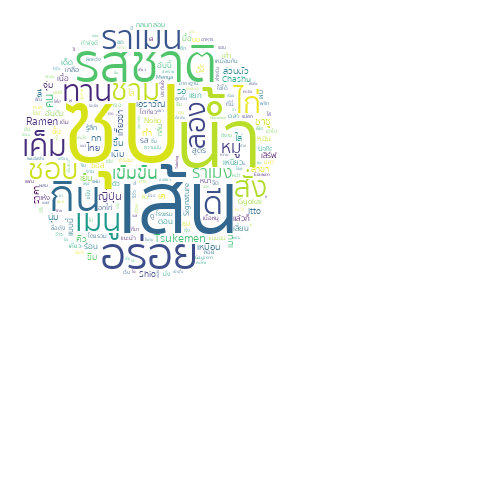

In [125]:
wordcloud.to_image()